In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)


In [2]:
# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'



Image.MAX_IMAGE_PIXELS = None  
# or
Image.MAX_IMAGE_PIXELS = 200000000  


def convert_to_rgb(image):
    if image.mode == 'P':  
        image = image.convert("RGBA")  
    if image.mode == "RGBA":  
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB") 
    return image



def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)  
    return image


train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  
    transforms.Lambda(convert_to_rgb),               
    transforms.RandomResizedCrop(224),               
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomVerticalFlip(p=0.2),            
    transforms.RandomRotation(degrees=15),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])



val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),             
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])


ImageFile.LOAD_TRUNCATED_IMAGES = True


MIN_IMAGE_FILE_SIZE = 3284  


def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        
        with Image.open(file_path) as img:
            img.verify()  
        return True
    except (OSError, Image.DecompressionBombError):
        return False


class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]


dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
from torch.utils.data import Subset

fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]


fake_subset_size = int(1.0/4.0 * len(fake_indices))
real_subset_size = int(1.0/4.0 * len(real_indices))

fake_subset_indices = fake_indices[fake_subset_size:fake_subset_size*2]  
real_subset_indices = real_indices[real_subset_size:real_subset_size*2]  

balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))

balanced_subset = Subset(dataset, balanced_subset_indices)

print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")


Original Dataset Size: 47998
Balanced Subset Size: 11999 (Fake: 6000, Real: 5999)


In [4]:
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 9599
Validation Dataset Size: 2400


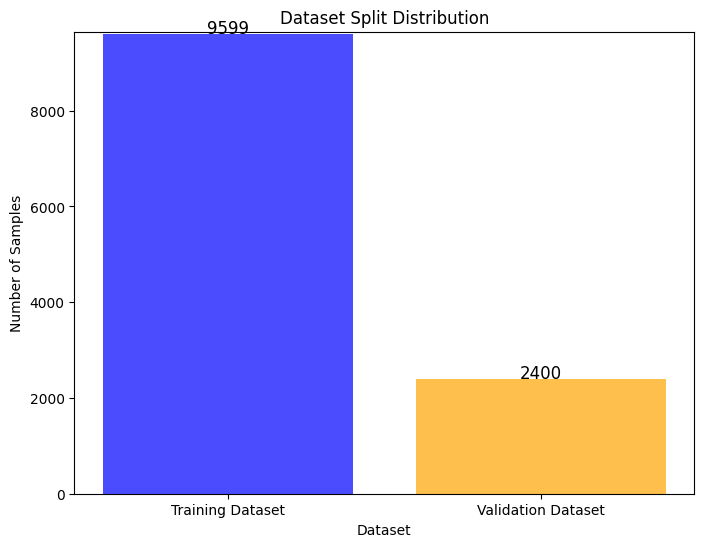

In [6]:
import matplotlib.pyplot as plt

train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import torch.nn as nn
from torchvision import models, transforms

from torchvision.models import resnet34

model =resnet34(weights=None)


num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 2)  
)
model.load_state_dict(torch.load("/kaggle/input/model-resnet34-after-1-training/pytorch/default/1/best_model7for_RESNET101_After_First_training__one-third-part.pth"))


model = model.to(device)


<ipython-input-8-94329e6cd701>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/model-resnet34-after-1-training/pytorch/defa

In [9]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
patience = 5
trigger_times = 0
best_val_loss = float('inf')

In [11]:
epochs = 10
best_val_acc = 0.0

# data={
#     "train_losses" : [],
#     "train_accuracies" : [],
#     "val_losses" : [],
#     "val_accuracies" : []
# }

In [12]:
df = pd.read_csv("/kaggle/input/score-of-resnet34-for-10-epcohes/scorse1_ResNet_101.csv")

data = df.to_dict(orient="list")

print(data)

{'train_losses': [0.5734998272016454, 0.4743225648479172, 0.4591502520439214, 0.3858638754585458, 0.364189382843927, 0.3507247774262442, 0.3389316792288898, 0.3396319232253137, 0.3283939269392772, 0.3321667350832528], 'train_accuracies': [0.7420564642150225, 0.7829982289821856, 0.7935201583498281, 0.8355036983019065, 0.8423794145223461, 0.8485258881133452, 0.8562350244817168, 0.8536305865194291, 0.8590478174809876, 0.8646734034795291], 'val_losses': [10.712988891601562, 0.5014767972628276, 0.4884221621354421, 0.3869033579031626, 0.3962781429290771, 0.3753858514626821, 0.3734327522913614, 0.3578917157649994, 0.366737189690272, 0.3584837702910105], 'val_accuracies': [0.4858333333333333, 0.785, 0.7679166666666667, 0.8258333333333334, 0.8304166666666667, 0.8379166666666668, 0.8387500000000001, 0.8483333333333334, 0.8425, 0.8541666666666667]}


In [13]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}for_RESNET34_After_second_training__one-half-part.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation loss: {best_val_loss:.4f}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4714 Acc: 0.7902
Val Loss: 0.7399 Acc: 0.7158

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.49      0.63      1188
        real       0.65      0.94      0.77      1212

    accuracy                           0.72      2400
   macro avg       0.77      0.71      0.70      2400
weighted avg       0.77      0.72      0.70      2400

Epoch 2/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4276 Acc: 0.8123
Val Loss: 0.4907 Acc: 0.7571

Classification Report:
              precision    recall  f1-score   support

        fake       0.80      0.68      0.73      1188
        real       0.73      0.83      0.78      1212

    accuracy                           0.76      2400
   macro avg       0.76      0.76      0.76      2400
weighted avg       0.76      0.76      0.76      2400

Epoch 3/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4289 Acc: 0.8089
Val Loss: 0.7143 Acc: 0.6846

Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.91      0.74      1188
        real       0.85      0.46      0.59      1212

    accuracy                           0.68      2400
   macro avg       0.73      0.69      0.67      2400
weighted avg       0.74      0.68      0.67      2400

Early stopping trigger count: 1/5
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4094 Acc: 0.8204
Val Loss: 0.4230 Acc: 0.8088

Classification Report:
              precision    recall  f1-score   support

        fake       0.86      0.74      0.79      1188
        real       0.77      0.88      0.82      1212

    accuracy                           0.81      2400
   macro avg       0.82      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400

Epoch 5/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3737 Acc: 0.8349
Val Loss: 0.3676 Acc: 0.8408

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.80      0.83      1188
        real       0.82      0.88      0.85      1212

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400

Epoch 6/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3590 Acc: 0.8500
Val Loss: 0.3575 Acc: 0.8483

Classification Report:
              precision    recall  f1-score   support

        fake       0.86      0.82      0.84      1188
        real       0.83      0.87      0.85      1212

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400

Epoch 7/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3453 Acc: 0.8515
Val Loss: 0.3577 Acc: 0.8508

Classification Report:
              precision    recall  f1-score   support

        fake       0.85      0.84      0.85      1188
        real       0.85      0.86      0.85      1212

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400

Early stopping trigger count: 1/5
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3511 Acc: 0.8546
Val Loss: 0.3626 Acc: 0.8408

Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.84      0.84      1188
        real       0.84      0.85      0.84      1212

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400

Early stopping trigger count: 2/5
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3463 Acc: 0.8558
Val Loss: 0.3617 Acc: 0.8413

Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.84      0.84      1188
        real       0.85      0.84      0.84      1212

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400

Early stopping trigger count: 3/5
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3536 Acc: 0.8485
Val Loss: 0.3568 Acc: 0.8392

Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.84      0.84      1188
        real       0.84      0.84      0.84      1212

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400

Best Validation Accuracy: 0.8508
Best Validation loss: 0.3568


In [14]:
df = pd.DataFrame(data)

In [15]:
data

{'train_losses': [0.5734998272016454,
  0.4743225648479172,
  0.4591502520439214,
  0.3858638754585458,
  0.364189382843927,
  0.3507247774262442,
  0.3389316792288898,
  0.3396319232253137,
  0.3283939269392772,
  0.3321667350832528,
  0.47141432811511236,
  0.42763471010700216,
  0.4288759749157253,
  0.40935796520985446,
  0.37372516985299226,
  0.3590123997447217,
  0.34533882150427475,
  0.3511320329237784,
  0.3463092586040149,
  0.3536380230262759],
 'train_accuracies': [0.7420564642150225,
  0.7829982289821856,
  0.7935201583498281,
  0.8355036983019065,
  0.8423794145223461,
  0.8485258881133452,
  0.8562350244817168,
  0.8536305865194291,
  0.8590478174809876,
  0.8646734034795291,
  0.7901864777580998,
  0.8122721116782998,
  0.8089384310865716,
  0.8203979581206375,
  0.8348786331909575,
  0.8499843733722263,
  0.8515470361495989,
  0.8545681841858527,
  0.8558183144077508,
  0.8485258881133452],
 'val_losses': [10.712988891601562,
  0.5014767972628276,
  0.4884221621354421

In [16]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.573500,0.742056,10.712989,0.485833
1,0.474323,0.782998,0.501477,0.785000
2,0.459150,0.793520,0.488422,0.767917
3,0.385864,0.835504,0.386903,0.825833
4,0.364189,0.842379,0.396278,0.830417
5,0.350725,0.848526,0.375386,0.837917
6,0.338932,0.856235,0.373433,0.838750
7,0.339632,0.853631,0.357892,0.848333
8,0.328394,0.859048,0.366737,0.842500
9,0.332167,0.864673,0.358484,0.854167


In [17]:
df.to_csv("/kaggle/working/scorse2_ResNet_34.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


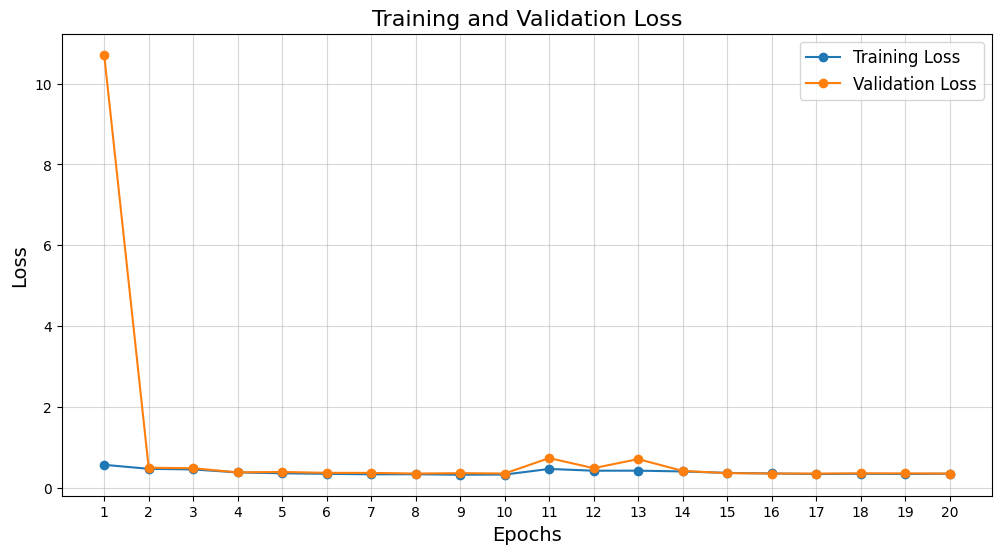

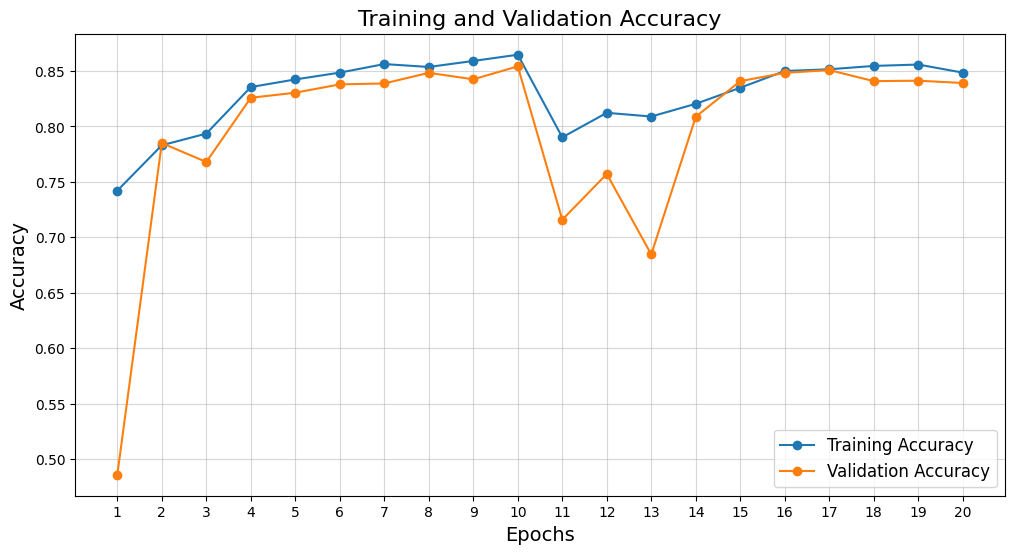

In [18]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["val_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["val_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()